In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from IPython.display import HTML
from matplotlib import animation

In [14]:
# Physical parameters

G = 4*np.pi**2           # grav constant in au^3 solar mass^-1 yr^-2
sma = 45                 # semimajor axis in au
dlt = 4                  # delta_a, width of debris disk in au
per = np.sqrt(sma**3)    # period in yr
frq = 1/per              # frequency in yr^-1
rho = 1                  # density of objects in g cm^-3
r_s = 7e10               # solar radius in cm
sma_cm = sma*1.5e13      # semimajor axis in cm
dlt_cm = dlt*1.5e13      # delta_a in m
alp_sun = r_s/(sma_cm)   # alpha, defined in Goldreich et al as solar radius / SMA
v_kep = np.sqrt(G/sma) * (1.5e13/3.15e7)     # keplerian velocity in cm s^-1
m0 = 1e2                 # initial mass in scatter belt in Earth masses

# Breaking energy law constants

A_stg = 4e7      # strength constant A in erg g^-1
B_stg = 3.3e-8    # strength constant B
s0 = 0            # size_0 of strength eq = 1 cm in log cm
alp_stg = -0.3    # strength constant alpha
bet_stg = 2       # strength constant beta

# Parameters of initial size distribution (power law)
alpha = 11/6   # Dohnanyi Law (Dohnanyi 1969)

# parameters of initial ecc distribution
#   TODO: parametrize ecc distribution at different sma
e0 = 0.1         # mean eccentricity of initial belt
e0_std = 0.001   # standard deviation

# parameters of grids

sMin = -4    # log10(sizes in cm)
sMax = 8

eMin = 0     # eccentricities 
eMax = 0.15

gps = 80    # gridpoints in size
gpe = 100    # gridpoints in ecc.     

In [15]:
# grid creation

size = np.linspace(sMin,sMax,gps)      
eccs = np.linspace(eMin,eMax,gpe)  

asp_rat = (sMax-sMin)/(eMax-eMin)

# integration parameters

ts = int(1e4) # number of timesteps

# arrays of integration

N = np.zeros((ts,gpe,gps))
Ndot = np.zeros((ts,gpe,gps))
N_i = np.zeros_like(Ndot)
N_o = np.zeros_like(Ndot)

# constant arrays

R = np.zeros((gps,gpe,gpe))
G = np.zeros((gps,gpe,gpe))
e_succ = np.zeros((gps,gpe,gpe))
successor = np.zeros((gps,gpe,gpe,gps))

In [16]:
def integrate_mass(sizes,numbers,comp='earth'):
    """
    In: sizes -- array; log sizes [cm] of each bin
        numbers -- array; log number of objects in each bin
        comp -- string ['earth','jupiter','pluto','none']; planet to compare total mass to
                           if 'none', return mass in grams
        
    Out: mtot -- float; total mass in disk, in earth masses
    """
    mass = (4*np.pi/3) * rho * (10**sizes)**3

    dm_ = mass[1:] - mass[:-1]
    mbin = (10**numbers[1:] + 10**numbers[:-1])/2
    
    mtot_g = np.nansum(mbin*dm_)

    if comp == 'earth':
        mtot = mtot_g/5.972e27
    elif comp == 'pluto':
        mtot = mtot_g/1.309e25
    elif comp == 'jupiter':
        mtot = mtot_g/1.899e30
    elif comp == 'none':
        mtot = mtot_g
    else:
        print('check your comparison name')
        return
        
    return mtot

def logamplitude(sizes,mtot,a):    
    scale = mtot*5.972e27 * (2-a) / ((4/3)*np.pi*rho)
    size_part = np.power(10,sizes[-1]*(6-3*a)) - np.power(10,sizes[0]*(6-3*a))
    amp = np.log10(scale) - np.log10(size_part)    # amplitude of number distribution
    
    return amp

def size_dist(s,mt,a):
    """
    In: s -- array; log sizes in cm
        mt -- float; total mass in earth masses
        a -- float; power law parameter alpha
        
    Out: s_bins -- array; log number of bodies in each size bin
    """
    if len(s) > 1:
        amp = logamplitude(s,mt,a)    
        s_scale = s*(3-3*a) + amp
    else:
        m_bin = (4*np.pi/3) * 10**(3*s)/5.972e27
        s_scale = np.log10(mt/m_bin)
        
    return s_scale

# I'm having an issue

The total mass in the initial size dist is not constant with the number of bins I use

In [17]:
bins_foo = np.logspace(1,5).astype(int)
mtotal = np.zeros(50)

for i in range(50):
    size_foo = np.linspace(-4,8,bins_foo[i])
    mtotal[i] = integrate_mass(size_foo, size_dist(size_foo,m0,alpha))

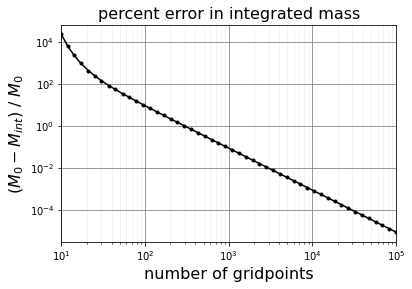

In [18]:
plt.plot(bins_foo,abs(m0 - mtotal)*100/m0,marker='o',markersize=3,c='k')
plt.xlabel('number of gridpoints',fontsize=16)
plt.ylabel(r'($M_0 - M_{int})$ / $M_0$',fontsize=16)
plt.title(r'percent error in integrated mass',fontsize=16)
plt.xlim(10,1e5)
#plt.ylim(1e-8,100)
plt.grid(True,which='major',c='grey')
plt.grid(True,which='minor',alpha=.2)
plt.yscale('log')
plt.xscale('log')
#plt.savefig('ev_intmass_issue.png',dpi=300)

I'm going to just ignore this issue for now. If it doesn't change over the course of integration it can be accounted for. 

# Setting up initial particle distribution

In [19]:
s_num = size_dist(size,m0,alpha)
e_numdens_unnorm = 1/np.sqrt(2*np.pi*e0_std**2) * np.exp(-0.5*(eccs-e0)**2/e0_std**2)
e_numdens = np.log10(e_numdens_unnorm / np.sum(e_numdens_unnorm))
N[0] = np.log10(np.outer(10**e_numdens,10**s_num))
#N = N.clip(min=0)

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_69359/3861476742.py:3: RuntimeWarning: divide by zero encountered in log10
  e_numdens = np.log10(e_numdens_unnorm / np.sum(e_numdens_unnorm))


### Plot size distribution, eccentricity distribution, $s-e$ distribution

total mass / input: 1.146668


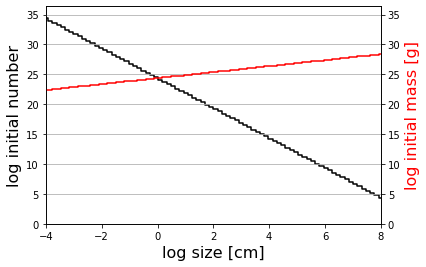

In [20]:
ax1 = plt.subplot()

ax1.step(size,s_num,c='k',where='mid')
plt.ylabel(r'log initial number',fontsize=16)
plt.xlabel('log size [cm]',fontsize=16)
plt.xlim(sMin,sMax)

ax2 = ax1.twinx()
ax2.step(size,3*size + s_num,c='r',where='mid')
ax2.set_ylabel(r'log initial mass [g]',fontsize=16,c='r')

ymin_foo = min(2, np.min(s_num),np.min(3*size + s_num))-2
ymax_foo = max(-2,np.max(s_num),np.max(3*size + s_num))+2
ax1.set_ylim(ymin_foo,ymax_foo)
ax2.set_ylim(ymin_foo,ymax_foo)
plt.grid(True,which='both',axis='y')
m_tot_int = integrate_mass(size, s_num, 'earth')
print('total mass / input: %.6f' %(m_tot_int/m0))
#plt.savefig('ev_size_dist.png',dpi=300)
plt.show()

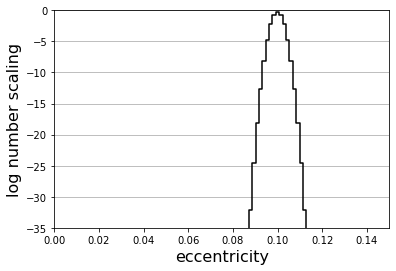

In [21]:
plt.step(eccs,e_numdens,where='mid',c='k',zorder=12)#,marker='o')
plt.xlabel('eccentricity',fontsize=16)
plt.ylabel(r'log number scaling',fontsize=16)
plt.xlim(eMin,eMax)
plt.ylim(-35,0)
plt.grid(True,which='both',axis='y')
plt.show()

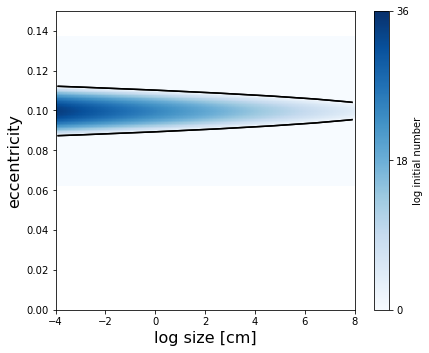

In [22]:
plt.figure(figsize=(7,5.5))
plt.imshow(N[0],origin='lower',extent=(sMin,sMax,eMin,eMax),vmin=0,aspect=asp_rat,cmap='Blues')
plt.colorbar(label='log initial number',ticks=[0,18,36])
plt.clim(0,36)
plt.contour(N[0],origin='lower',extent=(sMin,sMax,eMin,eMax),levels=[0,1e-11],colors='k')
plt.ylim(eMin,eMax)
plt.xlim(sMin,sMax)
plt.xlabel('log size [cm]',fontsize=16)
plt.ylabel('eccentricity',fontsize=16)
#plt.savefig('ev_se_dist.png',dpi=300)
plt.show()

Black contour shows the bins with only one particle ($\log N = 0$).

### Check to see if the size distribution is conserved

I don't know if the outer product to go from $N(e)$ and $N(s)$ to $N(s,e)$ will conserve the size distribution/total mass in the system. I'll check the total number in each column of the $s-e$ grid (each column corresponds to a size bin) compared to the total number in each size bin from the $N(s)$ distribution $\texttt{s}\_\texttt{num}$.

Sum each of the columns of $s-e$ space (making sure to take $10^N$, since the values in $N$ are $\log$ Number). Plot

$$
\text{Error}[i] = \frac{\texttt{s}\_\texttt{num}[i] - \sum_{j}^{g_e}10^{N[j,i]}}{\texttt{s}\_\texttt{num}[i]}
$$

total mass / input: 1.146668


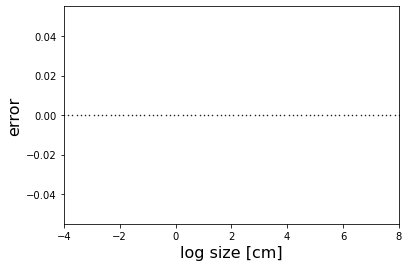

In [23]:
s_num_fromN = np.sum(10**N[0],axis=0)
m_tot_int = integrate_mass(size, np.log10(s_num_fromN), 'earth')
print('total mass / input: %1.6f' %(m_tot_int/m0))

plt.plot(size,(s_num - np.log10(s_num_fromN))/s_num,c='k',marker='o',ls='',markersize=.5)
plt.ylabel(r'error',fontsize=16)
plt.xlabel('log size [cm]',fontsize=16)
plt.xlim(sMin,sMax)
#plt.ylim(0,35)
plt.show()

Okay that's good.

## Defining breaking energy for all particles

In [24]:
def qstar(s1):
    term1 = A_stg * np.power(10,(s1-s0)*alp_stg)
    term2 = B_stg * 2.5 * 10**((s1-s0)*bet_stg)
    return term1 + term2

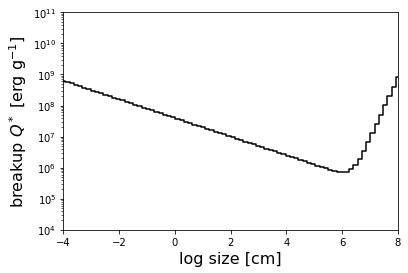

In [25]:
qsize = qstar(size)

plt.step(size,qsize,c='k',where='mid')
plt.xlabel('log size [cm]',fontsize=16)
plt.ylabel(r'breakup $Q^*$ [erg g$^{-1}$]',fontsize=16)
plt.ylim(1e4,1e11)
plt.xlim(sMin,sMax)
#plt.xscale('log')
plt.yscale('log')
plt.show()

## Defining collision velocity

Imagine all bodies with $e>0$ in a frame corotating with the local keplerian orbit ($e=0$ at the same semimajor axis). The eccentric bodies will carry out epicyclic motion, with velocities in the three spherical directions (radial, polar, and azimuthal. These velocities can be approximated as 

$$
v_r \sim e v_\text{kep}
\\
v_\theta \sim e v_\text{kep}
\\
v_\phi \sim i v_\text{kep}.
$$

Say two bodies can collide at any point in their epicyclic motion. The average relative velocity of the two bodies will be 

$$
v_\text{collision} = \sqrt{|\mathbf{v}_1 - \mathbf{v}_2|} \sim v_\text{kep} \sqrt{e_1^2 + e_2^2}
$$

In [26]:
def vcollision(e1,e2):
    vcoll = v_kep * np.sqrt(e1**2 + e2**2)
    return vcoll

## Finding smallest bullets

Below I fill the array $\texttt{G}$, which contains the size of a smallest bullet of eccentricity $e_2$ that can break a body of size $s_1$ and eccentricity $e_1$. $\texttt{G}$ is a $gp_s \times gp_e \times gp_e$ array, where element $(i,j,k)$ is the minimum-breaking size $s_2$ for $s_1 = \texttt{size[i]}$, $e_1 = \texttt{eccs[j]}$, and $e_2 = \texttt{eccs[k]}$.

This array will be constant through integration

In [27]:
def s2_break(s1, e1, e2):
    
    Q_ = qstar(s1)             # breaking energy in cm^2 / s^2
    omega = frq / (3.154e7)    # frequency in 1/s
    vcol = vcollision(e1,e2)
    denm = vcol**2 - 2*Q_
    s_ = 2*Q_ / denm
    
    s_ = s_.clip(min=0)
    size2 = 10**(s1) * np.power(s_,1/3)
    return np.log10(size2)

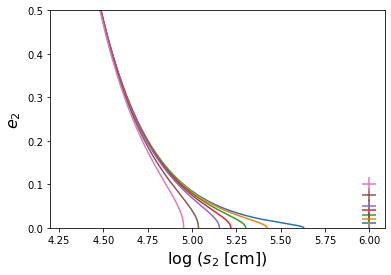

In [28]:
s1_test = 6
e1_test = [.01,.02,.03,.04,.05,.075,.1]
eccs_foo = np.linspace(.001,1,5000)
colors = ['C0','C1','C2','C3','C4','C5','C6','C7']
for i in range(len(e1_test)):
    s2_breakers = s2_break(s1_test,e1_test[i],eccs_foo)
    plt.plot(s2_breakers,eccs_foo,c=colors[i])
    plt.scatter(s1_test,e1_test[i],c=colors[i],marker='+',s=200)
plt.ylabel(r"$e_2$",fontsize=16)
plt.xlabel(r"log ($s_2$ [cm])",fontsize=16)
#plt.xscale('log')
#plt.xlim(2,4.5)
plt.ylim(0,.5)
#plt.xlim(7,8)
plt.show()

Above, each $+$ represents an example body with that size and eccentricity. For each colored cross, the line of the same color denotes the smallest possible bullets (at each bullet eccentricity) which can break the target body.

Now, I want to look at the smallest bullet of a given eccentricity $e_2$ that can break an body of a given size and eccentricity $e_1 = e_0$ (the peak initial eccentricity). 

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_69359/613319418.py:11: RuntimeWarning: divide by zero encountered in log10
  return np.log10(size2)


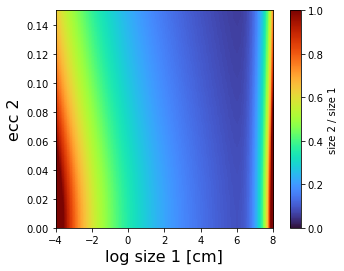

In [29]:
ss, ee = np.meshgrid(size,eccs)

s2s2_e10 = s2_break(ss,.10,ee)
s2s2_e20 = s2_break(ss,.20,ee)
s2s2_e05 = s2_break(ss,.05,ee)


#plt.contour(10**(s2s2 - size),origin='lower',extent=(sMin,sMax,eMin,eMax),
#            levels=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],cmap='Greys')
plt.imshow(10**(s2s2_e10 - size),origin='lower',extent=(sMin,sMax,eMin,eMax),aspect=asp_rat,vmin=0,vmax=1,cmap='turbo')
plt.colorbar(label='size 2 / size 1')
plt.ylabel('ecc 2',fontsize=16)
plt.xlabel('log size 1 [cm]',fontsize=16)
plt.xlim(sMin,sMax)
plt.ylim(eMin,eMax)
plt.show()

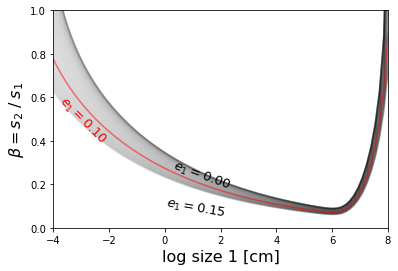

In [30]:
for i in range(gpe):
    plt.plot(size,10**(s2s2_e10 - size)[i],c='k',alpha=.05)
    
plt.plot(size,10**(s2s2_e10 - size)[66],c='r',alpha=.5)
plt.text(0.21,0.32,r'$e_1=0.00$',fontsize=13,c='k',va='top',rotation=-20)
plt.text(0,0.15,r'$e_1=0.15$',fontsize=13,c='k',va='top',rotation=-10)
plt.text(-3.9,0.62,r'$e_1=0.10$',fontsize=13,c='r',va='top',rotation=-45)
plt.ylim(0,1)
plt.xlim(sMin,sMax)
plt.xlabel('log size 1 [cm]',fontsize=16)
plt.ylabel(r'$\beta= s_2\;/\;s_1$',fontsize=16)
#plt.savefig('s2s1_sizes.png',dpi=300)
plt.show()

The plot above shows the size ratio required to break a body with a given size (x axis), with bullet eccentricity $e_2 = 0.10$. The gradient actually comes from individual lines with some transparency, such that darker regions indicate more lines. Each line represents a different body eccentricity --- notable ones are labelled.

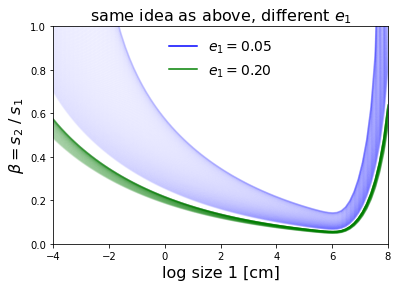

In [31]:
for i in range(gpe):
    plt.plot(size[s2s2_e05[i] > -np.inf],
             10**(s2s2_e05[i][s2s2_e05[i] > -np.inf] - size[s2s2_e05[i] > -np.inf]),
             c='b',alpha=.05,zorder=0)
    #plt.plot(size,10**(s2s2_e10 - size)[i],c='k',alpha=.05)
    plt.plot(size,10**(s2s2_e20 - size)[i],c='g',alpha=.05)

leg = plt.legend([r'$e_1 = 0.05$',r'$e_1 = 0.20$'],fontsize=14,frameon=False)
for lh in leg.legendHandles:
    lh.set_alpha(1)
    
plt.ylim(0,1)
plt.xlim(sMin,sMax)
plt.xlabel('log size 1 [cm]',fontsize=16)
plt.ylabel(r'$\beta= s_2\;/\;s_1$',fontsize=16)
plt.title(r'same idea as above, different $e_1$',fontsize=16)
plt.show()

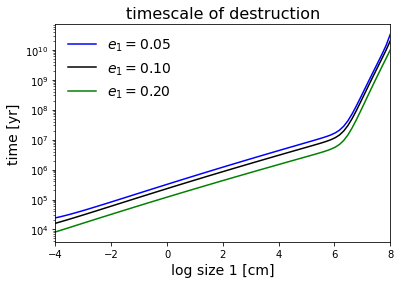

In [32]:
def timescale(size,beta):
    tau_D = 25*10**6 * (10**size / 10**6)**0.5 * ((1+beta)/1.1)**(-2) * (beta/0.1)**(2.5)
    return tau_D

plt.plot(size,timescale(size,10**(s2s2_e05 - size)[66]),c='b')
plt.plot(size,timescale(size,10**(s2s2_e10 - size)[66]),c='k')
plt.plot(size,timescale(size,10**(s2s2_e20 - size)[66]),c='g')

plt.legend([r'$e_1 = 0.05$',r'$e_1 = 0.10$',r'$e_1 = 0.20$'],fontsize=14,frameon=False)
plt.yscale('log')
plt.xlim(-4,8)
plt.ylabel('time [yr]',fontsize=14)
plt.xlabel('log size 1 [cm]',fontsize=14)
plt.title('timescale of destruction',fontsize=16)
plt.savefig('timescales.png',dpi=300)
plt.show()

### Most, but not all, collisions yield a drop in eccentricity

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_69359/613319418.py:11: RuntimeWarning: divide by zero encountered in log10
  return np.log10(size2)
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_69359/613319418.py:11: RuntimeWarning: divide by zero encountered in log10
  return np.log10(size2)


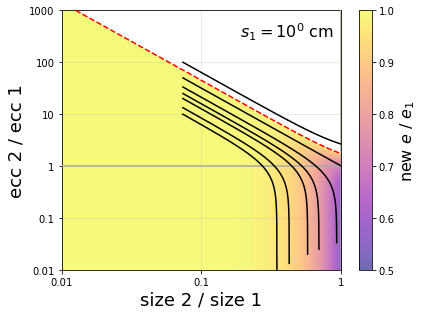

In [33]:
srat_foo = np.logspace(-2,1,200)
erat_foo = np.logspace(-3,3,200)

ssrat, eerat = np.meshgrid(srat_foo,erat_foo)

eps_foo = np.sqrt(1 + ssrat**6 * eerat**2)/(1 + ssrat**3)

fig,ax=plt.subplots(figsize=(6,4.5))

s1_test = 0
for i in range(len(e1_test)):
    s2_breakers = s2_break(s1_test,e1_test[i],eccs_foo)
    plt.plot(np.log10(10**s2_breakers/10**s1_test),np.log10(eccs_foo/e1_test[i]), 
                 c='k',zorder=9)
    
#s2_breakers = s2_break(8,e1_test[0],eccs_foo)
#plt.plot(np.log10(10**s2_breakers/10**8),np.log10(eccs_foo/e1_test[0]), 
#            'C0',alpha=.8,zorder=9)

#s2_breakers = s2_break(-4,e1_test[0],eccs_foo)
#plt.plot(np.log10(10**s2_breakers/10**(-4)),np.log10(eccs_foo/e1_test[0]), 
#            'C0',alpha=.8,zorder=9)
    

#plt.text(-1.6,1.55,r'$e_1=$')
"""plt.text(-.95,np.log10(eccs_foo[-1]/e1_test[0])-.05,e1_test[0],ha='right')
plt.text(-.95,np.log10(eccs_foo[-1]/e1_test[1])+.03,e1_test[1],ha='right')
plt.text(-.95,np.log10(eccs_foo[-1]/e1_test[2])+.04,e1_test[2],ha='right')
plt.text(-.95,np.log10(eccs_foo[-1]/e1_test[3])-.00,e1_test[3],ha='right')
plt.text(-.95,np.log10(eccs_foo[-1]/e1_test[4])-.08,e1_test[4],ha='right')
plt.text(-.95,np.log10(eccs_foo[-1]/e1_test[5])-.06,e1_test[5],ha='right')
plt.text(-.95,np.log10(eccs_foo[-1]/e1_test[6])-.11,e1_test[6],ha='right')"""

plt.text(-.05,2.8,r'$s_1 = 10^{%1.i}$ cm' %s1_test, ha='right',va='top',fontsize=16,rotation=0)
"""
plt.text(-.95,1.75,r'$e_1=$',c='C0')
plt.text(-.85,1.50,e1_test[0],c='C0',alpha=.8)
#plt.text(.28,1.1,r'$s_1 = 10^%1.i$ cm' %8,c='C0',alpha=.8)
#plt.text(.21,0.45,r'$s_1 = 10^{%1.i}$ cm' %(-4),c='C0',alpha=.8)
"""


#plt.legend(labels=[r"$e_1 = 0.01$", r"$e_1 = 0.10$", r"$e_1 = 0.25$", r"$e_1 = 0.50$", r"$e_1 = 0.75$"],loc='upper right')

plt.imshow(eps_foo,origin='lower',extent=(-2.1,1.1,-3.1,3.1),aspect=1.3/3.5,vmin=0.5,vmax=1,cmap='plasma',alpha=.6)
plt.colorbar().set_label(label=r'new $e$ / $e_1$', fontsize=16)

plt.fill_between(np.log10(srat_foo), np.log10(np.sqrt(2*srat_foo**(-3)+1)),np.full_like(srat_foo,1000),facecolor='white')
plt.plot(np.log10(srat_foo), np.log10(np.sqrt(2*srat_foo**(-3)+1)),'r--',zorder=12)

plt.ylabel('ecc 2 / ecc 1',fontsize=18)
plt.xlabel('size 2 / size 1',fontsize=18)

plt.yticks([-3,-2,-1,0,1,2,3],labels=[0.001,0.01,0.1,1,10,100,1000])
plt.xticks([-2,-1,0,1],labels=[0.01,0.1,1,10])
plt.ylim(-2,3)
plt.xlim(-2,0)

plt.grid(True,alpha=.3)
plt.plot([0,0],[-4,4],c='darkgrey',zorder=4)
plt.plot([-4,4],[0,0],c='darkgrey',zorder=4)

fig.tight_layout()
#fig.savefig('ratios_s2s1-e2e1.png',dpi=300)
plt.show()

Black lines show $e$ ratios vs $s$ ratios for a range of colliders for a target body having the eccentricity $[.01, .02, .03, .04, .05, .075, .10]$, from top to bottom. Size of the target body is listed in the upper right corner. Collisions above the dashed red line result in a *higher* eccentricity than the target body initially had.

## Setting rates of relevant collisions

We only care about the collisions between the smallest possible bullets for a given body, since all other bullets would be orders-of-magnitude more sparse and therefore have orders-of-magnitude lower rates of collision. We fill $\texttt{R}$ with the rates of the respective collisions detailed in $\texttt{G}$. 

In [34]:
def rate(s1,s2):
    """
    In:  s1, s2 -- float; sizes of colliding bodies in m
         
    Out: f -- 1D array; rates of collisions for all bodies
    """
    numer = np.pi * (10**s1 + 10**s2)**2
    denom = 2 * np.pi * sma_cm * per * dlt_cm
    f = numer / denom
    return np.log10(f)

## Eccentricities of successors

I fill the array $\texttt{e_succ}$ with the center of mass eccentricity of the collisions detailed in $\texttt{G}$. Assuming all the successor particles will come away from the collision with this eccentricity

In [35]:
def ecc_com(s1,s2,e1,e2):
    s1 = 10**s1
    s2 = 10**s2
    numer = np.sqrt(s1**6 * e1**2 + s2**6 * e2**2)
    denom = s1**3 + s2**3
    
    ecc = numer/denom
    return ecc

## Sizes of successors

Collisions between bodies of $s_1$ and $s_2$ will lead to a cloud of bodies with a mass distribution, defined in Gaspar et al (2012)

In [36]:
def size_succ(s1,s2,e1,e2):
    """
    In: s1 -- float
        s2 -- float
        e1 -- float
        e2 -- array (any length N)
        
    Out: number -- N-by-gps array
    """
    m1, m2 = (4/3)*np.pi*rho*10**(s1*3), (4/3)*np.pi*rho*10**(s2*3)
    vcol = vcollision(e1,e2)
    Q_ = qstar(s1)
    C = 0.5 * (m2/m1) * (vcol**2/Q_)
    X = 0.5 * m1 * C**(-1.24)
    s_X = np.log10(np.power(3*X/(4*np.pi*rho) ,1/3))
    m_redist = (m1 + m2)/5.972e27
    
    number = np.zeros((len(e2),gps))
    for i in range(len(e2)):
        s_X_bin = ((np.abs(s_X[i] - size)).argmin()).astype(int)
        number[i] = np.append(size_dist(size[:s_X_bin+1], m_redist[i], alpha), np.log10(np.zeros(gps-s_X_bin-1)))
    return number

In [37]:
%%time
#for i in range(gpe):
dens_break_foo = size_succ(-3.9,s2_break(-3.9,eccs[65],eccs),eccs[65],eccs)

CPU times: user 3.32 ms, sys: 1.65 ms, total: 4.97 ms
Wall time: 3.54 ms


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_69359/84492167.py:21: RuntimeWarning: divide by zero encountered in log10
  number[i] = np.append(size_dist(size[:s_X_bin+1], m_redist[i], alpha), np.log10(np.zeros(gps-s_X_bin-1)))


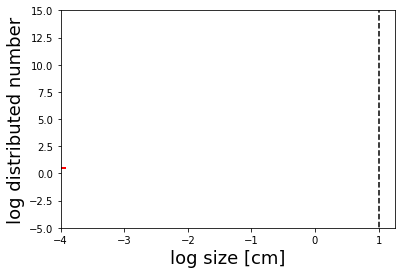

In [38]:
test_size1 = np.log10(10)

plt.step(size,dens_break_foo[63],c='r',lw=2,zorder=0,where='mid')

plt.plot(np.full(2,size[np.argmin(abs(test_size1-size))]),[-20,100],c='k',ls='--')
plt.ylabel('log distributed number',fontsize=18)
plt.xlabel('log size [cm]',fontsize=18)
plt.xlim(-4)
plt.ylim(-5,15)
plt.show()

In [39]:
print(integrate_mass(size,dens_break_foo[63],'none'))

1.134011217844592e-11


# Actually filling all of my arrays

In [40]:
%%time
for n in range(gps):
    s1 = size[n]      # focus on a single target body size
    for i in range(gpe):     
        e1 = eccs[i]        # focus on a single target eccentricity
        e2 = eccs           # but consider the whole range of bullet eccs at once

        G[n,i,:] = s2_break(s1,e1,e2)   # fill G with the size of bullet that will break s1, e1 when having e2 
        R[n,i,:] = rate(s1,G[n,i,:])    # fill R with the one-to-one rate of collisions between body and bullet
        e_succ[n,i,:] = ecc_com(s1,G[n,i,:],e1,e2)       # fill e_succ with typical COM ecc. for this collision
        successor[n,i,:] = size_succ(s1,G[n,i,:],e1,e2)  # fill successor with log # of fragments in each size bin
        
    if n%10 == 0:
        print(n)     # print to make sure it's running (useful with more bins)

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_69359/613319418.py:11: RuntimeWarning: divide by zero encountered in log10
  return np.log10(size2)
/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_69359/84492167.py:14: RuntimeWarning: divide by zero encountered in power
  X = 0.5 * m1 * C**(-1.24)


0
10
20
30
40
50
60
70
CPU times: user 16.1 s, sys: 140 ms, total: 16.2 s
Wall time: 16.2 s


These arrays are now full of the things I said I'd fill them with. Below we can look at different slices of them.

3.59493670886076


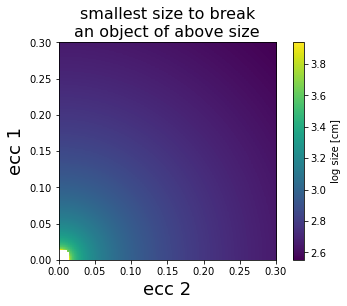

In [41]:
idx_foo = 50
print(size[idx_foo])
plt.imshow(G[idx_foo],origin='lower',extent=(0,.3,0,.3))#,norm=LogNorm(vmin=.3,vmax=2))
plt.xlabel('ecc 2',fontsize=18)
plt.ylabel('ecc 1',fontsize=18)
plt.title('smallest size to break\nan object of above size',fontsize=16)
plt.colorbar(label='log size [cm]')
plt.show()

3.59493670886076


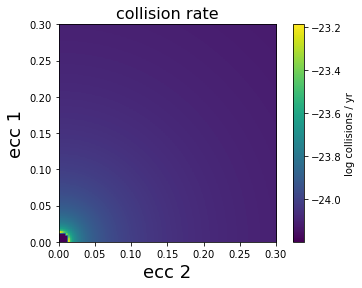

In [42]:
print(size[idx_foo])
plt.imshow(R[idx_foo],origin='lower',extent=(0,.3,0,.3))#,norm=LogNorm(vmin=1.4e-25,vmax=2e-25))
plt.xlabel('ecc 2',fontsize=18)
plt.ylabel('ecc 1',fontsize=18)
plt.title(r'collision rate',fontsize=16)
plt.colorbar(label='log collisions / yr')
plt.show()

The collision rate of a target body with its smallest possible bullet (a different size at each point in the grid) *if* there's only one of each of them.

### The change in eccentricity is actually really small

Huh

ecc 1 = 0.1000


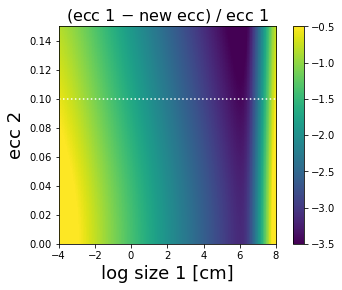

In [43]:
ecc_idx = 66
print('ecc 1 = %0.4f' %(eccs[ecc_idx]))
plt.imshow(np.log10((eccs[ecc_idx] - e_succ[:,ecc_idx,:].T)/eccs[ecc_idx]),
           extent=(sMin,sMax,eMin,eMax),origin='lower',aspect=asp_rat,vmin=-3.5,vmax=-.5)
plt.colorbar()
plt.plot([sMin,sMax],np.full(2,eccs[ecc_idx]),c='white',ls=':')

plt.ylabel('ecc 2',fontsize=18)
plt.xlabel('log size 1 [cm]',fontsize=18)
plt.title(r'(ecc 1 $-$ new ecc) / ecc 1',fontsize=16)
plt.show()

Eccentricity of the successor particles relative to the eccentricity of the progenitor body. White dotted line shows the eccentricity of the progenitor body. The slice of this plot at that line represents the cooling of bodies of various sizes by bullets with the same eccentricity --- since we start off with a thin distribution of eccentricities (centered around this line) this is perhaps the most pertinent slice of this plot. 

## Array Flattening

I now want to flatten these arrays to simplify the following work. To do this, I can flatten the successor size number density 4D array to a 2D array, where each row contains the number density of each size for a given collision. Transposing the rows and columns of the 3D arrays allows us to flatten them such that the indices match up.

In [44]:
succdist_flat = successor.reshape((gps*gpe*gpe,gps))
G_flat = G.transpose(0,2,1).ravel()
R_flat = R.transpose(0,2,1).ravel()
e_succ_flat = e_succ.ravel()

### Make sure the flattening worked properly

Below I look at one collision using the 3D/4D arrays, and make sure the corresponding collision in the flattened arrays actually corresponds. The flattened-array index corresponding to element $[i,j,k]$ of a 3D/4D array should be given by

$$
\texttt{flat}\_\texttt{idx} = i g_e^2 + j g_e + k
$$

Index: (75, 56, 64)
Index: (75, 56, 64)


size 2 = 10^6.8920695278560391 cm
size 2 = 10^6.8920695278560391 cm


e_succ = 0.08230687568706568
e_succ = 0.08230687568706568


R = 10^-16.3649927463540941 / yr
R = 10^-16.3649927463540941 / yr


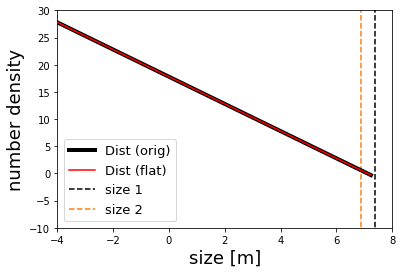

In [45]:
testi = 75
testj = 56
testk = 64

flatidx = testi*gpe*gpe + testj*gpe + testk

# print a bunch of checks that we got our flat index right
print('Index: (%2.i, %2.i, %2.i)'%(testi,testj,testk))
print('Index:',np.unravel_index(flatidx,(gps,gpe,gpe)))  
print('\n')
print('size 2 = 10^%1.16f' %G_flat[flatidx],'cm')
print('size 2 = 10^%1.16f' %G[testi,testj,testk],'cm')
print('\n')
print('e_succ =',e_succ_flat[flatidx])
print('e_succ =',e_succ[testi,testj,testk])
print('\n')
print('R = 10^%1.16f' %R_flat[flatidx],'/ yr')
print('R = 10^%1.16f' %R[testi,testj,testk],'/ yr')

plt.plot(size,successor[testi,testj,testk,:],c='k',lw=4,zorder=10)
plt.plot(size,succdist_flat[flatidx,:],c='r',zorder=12,alpha=1)
plt.plot(np.full(2,size[testi]),[-25,35],c='k',ls='--')
plt.plot(np.full(2,G[testi,testj,testk]),[-25,35],c='C1',ls='--')

plt.legend(labels=['Dist (orig)','Dist (flat)','size 1','size 2'],loc='lower left',fontsize=13)
plt.ylabel('number density',fontsize=18)
plt.xlabel('size [m]',fontsize=18)
plt.xlim(-4,8)
plt.ylim(-10,30)
plt.show()

So now we have four relevant arrays: $\texttt{G\_flat}$, containing the smallest bullet sizes; $\texttt{R\_flat}$, containing the rates of collisions between bodies with $s_1$, $e_1$, $e_2$, and $s_2$ from $\texttt{G\_flat}$; $\texttt{e\_succ\_flat}$, containing the resultant eccentricities from such collisions; and $\texttt{succdist\_flat}$, where each element of axis 0 is an array with the number density at each size resultant from the collision. 

Therefore I can figure out which indices in our flattened arrays feed into which bins of eccentricity size. Multiplying $\texttt{R\_flat}$ by $\texttt{succdist\_flat}$ gives the number density rate of change in each size bin. We must then multiply this by the relevant number densities of particles present to get the *actual* rate of change. Using this final array, we can sum the indices relevant to each eccentricity bin and get the rate of change in each bin of $s-e$ space. These last two steps -- 1) multiplication of $\texttt{R\_flat}\cdot\texttt{succdist\_flat}$ by relevant densities, and 2) summing to find rates of change on our 2D grid -- need to happen at every step.

## Filling $\texttt{idx}$ arrays

The above arrays have a bunch of real numbers for sizes and eccentricities pertaining to each collision --- it will be helpful to note down the bins corresponding to these values.

The array $\texttt{esucc}\_\texttt{idx}$ will contain the eccentricity bin number for the fragments from each collision.

$\texttt{eidx}\_\texttt{colls}$ will be an array (length $g_e$) of strings. Each element will contain all of the indices of the collisions which will result in eccentricity in a given bin.

$\texttt{nidx}$ will be a 2D array of shape $g_e \times g_s$. Each element will have a string with the indices of the collisions which use that bin.

The array $\texttt{idx}$ will contain the indices of the bullet and main body on the $s-e$ grid for each collision.

In [46]:
esucc_idx = np.zeros_like(e_succ_flat)                # empty array len=num_colls
for i in range(len(e_succ_flat)):                     # for each collision
    esucc_idx[i] = ((np.abs(eccs - e_succ_flat[i])).argmin()).astype(int)     # record index of successor eccentricity bin

#eidx_colls = []
#for i in range(gpe):
 #   where = np.where(esucc_idx == i)
 #   idx_e_foo = np.nonzero(where)        # returns indices of where != 0
 #   eidx_colls.append(idx_e_foo)      # adds those indices as a new element of eidx_colls

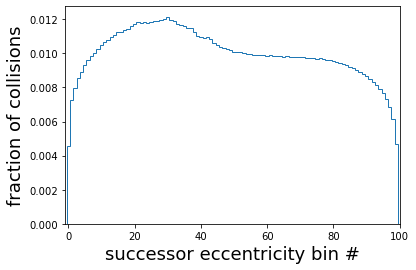

In [47]:
#for i in range(gpe):
 #   plt.plot(i,len(eidx_colls[i][0])/len(e_succ_flat),marker='o',c='k',markersize=2,zorder=12)
plt.hist(e_succ_flat*((gpe-1)/(eMax-eMin)),bins=gpe,density=True,histtype='step',range=(-.5,gpe-.5))
plt.ylabel('fraction of collisions',fontsize=18)
plt.xlabel('successor eccentricity bin #',fontsize=18)
#plt.ylim(0,.006)
plt.xlim(-1,gpe)
#plt.savefig('ev_ebins_fromcolls.png',dpi=300)
plt.show()

Our binning of successor eccentricity is accurate --- blue histogram shows the fraction of collisions from $\texttt{e}\_\texttt{succ}$, while the black dots show the fraction of collisions from the number of collisions recorded as yielding a certain eccentricity in $\texttt{eidx}\_\texttt{colls}$.

We now need to record the other bins relevant to each collision in $\texttt{idx}$.

In [48]:
num_colls = gps*gpe*gpe
idx = np.zeros((num_colls,4))

s1_idx, e1_idx, e2_idx = np.unravel_index(range(num_colls),(gps,gpe,gpe))

s2_idx = np.zeros(num_colls)
for i in range(num_colls):
    s2_idx[i] = (np.abs(size - G_flat[i])).argmin()

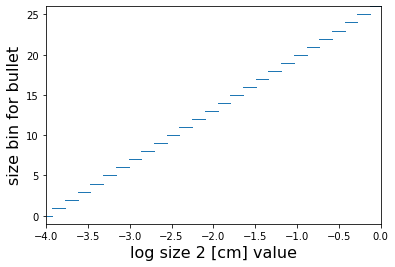

In [49]:
plt.plot(G_flat,s2_idx,marker='|',ls='',markersize=.5)
plt.ylabel('size bin for bullet',fontsize=16)
plt.xlabel('log size 2 [cm] value',fontsize=16)
plt.ylim(-1,int(gps/3))
plt.xlim(-4,0)
plt.show()

In [50]:
idx[:,0] = s1_idx
idx[:,1] = e1_idx
idx[:,2] = s2_idx
idx[:,3] = e2_idx

idx = idx.astype('int')

R_flat[idx[:,0] < idx[:,2]] = -np.inf                    # say that collisions where s2 > s1 don't exist
R_flat[G_flat < sMin] = -np.inf                          # say that collisions where s2 < min size don't exist

One last lookup table:

In [51]:
RNS = succdist_flat + R_flat.reshape((R_flat.size,1))
RNS = np.nan_to_num(RNS, nan=-np.inf, neginf=-np.inf)

The above array $\texttt{RNS}$ is the rate of flow into different number bins from the various collisions. These can be multiplied by the corresponding $N_{body}$ and $N_{bullet}$ for those collisions at each step in the integration to give the actual rate of insertion into each size bin from each collision. In the cell below, I create nrem_all, which looks at the *actual* rate of occurrence for each collision --- this will vary over time with the number present of each body/bullet in each collision.

In [52]:
n1_all = N[0,idx[:,1],idx[:,0]]
n2_all = N[0,idx[:,3],idx[:,2]]

nrem_all = np.zeros((ts,num_colls))
nrem_all[0] = R_flat + (n1_all + n2_all)

This is mostly useful for looking at the collisions themselves; it doesn't tell us much about the evolution on its own. I will also refer to it in each step of the integration. 

In [53]:
def max_s_succ(s1,e1,s2,e2):
    m1 = (4/3) * np.pi * rho * 10**(s1*3)
    m2 = (4/3) * np.pi * rho * 10**(s2*3)

    vcol = vcollision(e1,e2)           # len=N array; collision velos
    Q_ = qstar(s1)                     # float; energy to break star

    C = 0.5 * (m2/m1) * (vcol**2/Q_)   # array; constant from ?????
    m_X = 0.5 * m1 * C**(-1.24)        # array; maximum succsessor MASS [g]

    s_X = np.power( m_X * 3/(4*np.pi*rho) , 1/3)     # array; maximum successor SIZE [cm]
    return s_X

def efault(s):
    """
    - For a given size, defines the minimum e for which a catastrophic collision can occur
    - Assumes both body and bullet have same e
    - If e < efail, 2*Q_star > vcol**2 --> not enough energy to break up
    
    In: s -- float; size, in meters
    Out: efail -- float; min eccentricity
    """
    Q_ = qstar(s)
    efail = np.sqrt(2*Q_)/v_kep
    return efail

In [54]:
sfail = (np.linspace(0,14,400)-1)*gps/(sMax-sMin)
efail = efault(np.linspace(-5,9,400))

typical_e_into = np.zeros((gpe,gps))
maximum_s_into = np.zeros((gpe,gps))
for i in range(gps):
    for n in range(gpe):
        relevant_collisions = np.argwhere((idx[:,0] == i) & (idx[:,1] == n) & (idx[:,0] > idx[:,2]) & (G_flat > sMin))
        
        if len(relevant_collisions) > 0:
            numerator = np.nansum(esucc_idx[relevant_collisions])#*10**nrem_all[0,relevant_collisions])
            denominat = np.sum(10**nrem_all[0,relevant_collisions])
            typical_e_into[n,i] = numerator/len(relevant_collisions)

            numerator = 0
            for c in relevant_collisions:
                dist_vals_foo = np.argwhere(np.abs(succdist_flat[c]) != np.inf)[:,1]
                if dist_vals_foo.shape[0] > 0 :
                    numerator += np.nanmax(dist_vals_foo)#*10**nrem_all[0,c]
            maximum_s_into[n,i] = (numerator/len(relevant_collisions))

/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_69359/2224632445.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,'%1.2f' %(eMax/5), '%1.2f' %(2*eMax/5), '%1.2f' %(3*eMax/5), '%1.2f' %(4*eMax/5), '%1.2f' %(eMax)])


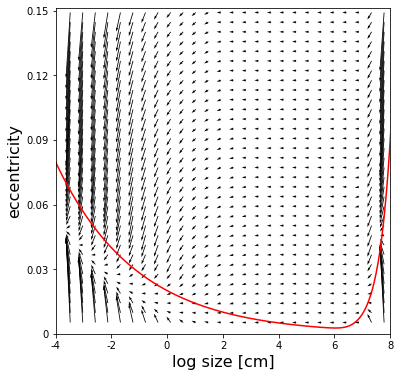

In [55]:
fig,ax=plt.subplots(figsize=(6,6))

sparsity = 3
startfoo = 3

ge_zoom = 100
gs_zoom = 80

ss,ee = np.meshgrid(np.arange(gs_zoom),np.arange(ge_zoom))
ss_sparse = ss[startfoo::sparsity,startfoo::sparsity]
ee_sparse = ee[startfoo::sparsity,startfoo::sparsity]

sparse_typical_e = typical_e_into[startfoo:ge_zoom:sparsity,startfoo:gs_zoom:sparsity]
sparse_maximum_s = maximum_s_into[startfoo:ge_zoom:sparsity,startfoo:gs_zoom:sparsity]

#ax.imshow(N[0],origin='lower',aspect=80/100,vmin=0,vmax=38,extent=(0.5,79.5,0.5,99.5),cmap='Greens')

ax.quiver(ss_sparse + 0.5, 
          ee_sparse + 0.5,
          (sparse_maximum_s - ss_sparse), 
          (sparse_typical_e - ee_sparse),
          color='k',scale=gs_zoom,scale_units='width')

ax.plot(sfail,efail*gpe/(eMax-eMin),c='r')
plt.xlabel('log size [cm]',fontsize=16)
plt.ylabel('eccentricity',fontsize=16)
plt.xlim(0,gs_zoom+1)
plt.ylim(0,ge_zoom+1)

ax.set_yticklabels([0,'%1.2f' %(eMax/5), '%1.2f' %(2*eMax/5), '%1.2f' %(3*eMax/5), '%1.2f' %(4*eMax/5), '%1.2f' %(eMax)])
ax.set_xticks([0,13.3,26.6,40,53.3,66.6,80])
ax.set_xticklabels([-4,-2,0,2,4,6,8])
ax.set_xlim(0,80)
#plt.colorbar()
#plt.savefig('motion_between.png',dpi=300)
plt.show()

## Finally, for fun, a collision

We look at the details of a randomly-chosen collision:

size 1: 0.00233 cm;   eccentricity 1: 0.1258
size 2: 0.00116 cm;   eccentricity 2: 0.0424
o_1 index: [ 9,83]
o_2 index: [ 7,28]


log Number of target bodies: -113.328
log Number of bullets:       -inf


mass 1: 0.0000000529 g
mass 2: 0.0000000065 g
total mass in collision: 0.0000000594 g
total mass in fragments: 0.0000000769 g


successor eccentricity: 0.1169
successor e_idx: 77


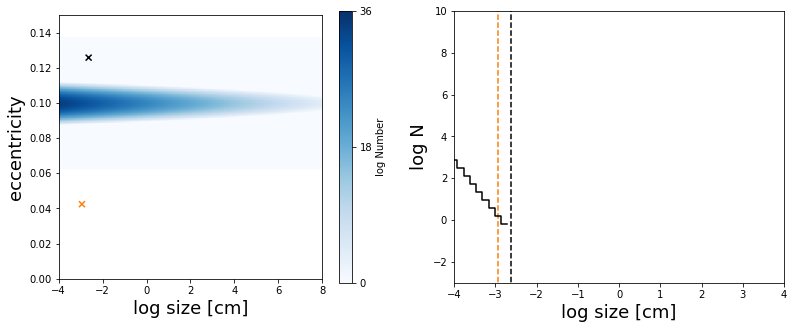

In [72]:
idx_foo_long = 98328

# printing information about this specific collision

print('size 1: %4.5f' %(10**size[idx[idx_foo_long,0]]),'cm;   eccentricity 1: %1.4f' %eccs[idx[idx_foo_long,1]])
print('size 2: %4.5f' %(10**size[idx[idx_foo_long,2]]),'cm;   eccentricity 2: %1.4f' %eccs[idx[idx_foo_long,3]])
print('o_1 index: [%2.i,%2.i]' %(idx[idx_foo_long,0],idx[idx_foo_long,1]))
print('o_2 index: [%2.i,%2.i]' %(idx[idx_foo_long,2],idx[idx_foo_long,3]))
print('\n')
print('log Number of target bodies: %2.3f' %N[0,idx[idx_foo_long,1], idx[idx_foo_long,0]])
print('log Number of bullets:       %2.3f' %N[0,idx[idx_foo_long,3], idx[idx_foo_long,2]])
print('\n')

mass1_foo = (4/3)*np.pi*rho*10**(size[idx[idx_foo_long,0]]*3)
mass2_foo = (4/3)*np.pi*rho*10**(size[idx[idx_foo_long,2]]*3)

print('mass 1: %3.10f' %mass1_foo,'g')
print('mass 2: %3.10f' %mass2_foo,'g')
print('total mass in collision: %3.10f' %(mass1_foo+mass2_foo),'g')
print('total mass in fragments: %3.10f' %(integrate_mass(size,succdist_flat[idx_foo_long,:])*5.972e27),'g')
print('\n')
print('successor eccentricity: %1.4f' %e_succ_flat[idx_foo_long])
print('successor e_idx: %2.i' %esucc_idx[idx_foo_long])


# plotting information about this specific collision

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(13,5))
a = ax1.imshow(N[0],origin='lower',extent=(sMin,sMax,eMin,eMax),aspect=asp_rat,vmin=0,vmax=36,cmap='Blues')
fig.colorbar(a, ax=ax1,label='log Number',ticks=[0,18,36])
ax1.scatter(size[[idx[idx_foo_long,0],idx[idx_foo_long,2]]],
            eccs[[idx[idx_foo_long,1],idx[idx_foo_long,3]]],marker='x',c=['k','C1'])
ax1.set_xlabel('log size [cm]',fontsize=18)
ax1.set_ylabel('eccentricity',fontsize=18)
ax1.set_xlim(sMin,sMax)
ax1.set_ylim(eMin,eMax)

ax2.step(size,succdist_flat[idx_foo_long,:],c='k',zorder=12,alpha=1,where='mid')
ax2.plot(np.full(2,size[idx[idx_foo_long,0]]),[-25,35],c='k',ls='--')
ax2.plot(np.full(2,size[idx[idx_foo_long,2]]),[-25,35],c='C1',ls='--')

ax2.set_xlim(-4,4)
ax2.set_ylim(-3,10)
ax2.set_xlabel('log size [cm]',fontsize=18)
ax2.set_ylabel('log N',fontsize=18)

plt.show()

## Collision statistics

In [73]:
print('Number of colls that happen more than ~ once / Hubble time:',
      np.count_nonzero(np.where(nrem_all[0] > -10,1,0)))

Number of colls that happen more than ~ once / Hubble time: 11072


3.59493670886076


/var/folders/y4/2ycbkc7559gd7v34zsxpc8dh0000gn/T/ipykernel_37736/386350836.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(ecc_change_real.flatten()),range=(-6,0),bins=30,facecolor='C1')


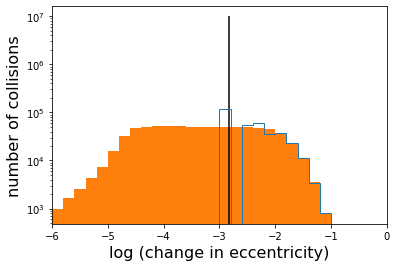

In [74]:
print(size[idx_foo])

bin_de = (eMax - eMin)/gpe

plt.vlines(np.log10(bin_de),0,1e7,color='k')

ecc_change_real = abs(eccs[idx[:,1]] - e_succ_flat)

plt.hist(np.log10(ecc_change_real.flatten()),range=(-6,0),bins=30,facecolor='C1')

ecc_change_fromidx = abs(eccs[idx[:,1]] - eccs[esucc_idx.astype(int)])

plt.hist(np.log10(ecc_change_fromidx),range=(-6,0),bins=30,edgecolor='C0',histtype='step')
plt.xlim(-6,0)
#plt.ylim(1e4,1e7)
plt.yscale('log')
plt.ylabel('number of collisions',fontsize=16)
plt.xlabel('log (change in eccentricity)',fontsize=16)
plt.show()

Orange: histogram of the change in eccentricity ($|e_1 - e_{succ}|$) from each collision. Blue: same histogram, but using the eccentricity index of the successors instead of the raw successor eccentricity. The bin width is plotted as a black line --- collisions below this line will not register a drop in eccentricity.

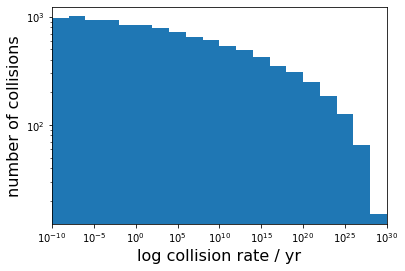

In [75]:
plt.hist(10**nrem_all[0],bins=np.logspace(-10,30,21))
#plt.plot(np.linspace(-10,30),)
plt.ylabel('number of collisions',fontsize=16)
plt.xlabel('log collision rate / yr',fontsize=16)
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-10,1e30)
#plt.ylim(1e3)
#plt.ylim(1e2,1e5)
plt.show()

Most collisions occur at a rate $\ll 10^{-6} \text{ per year}$

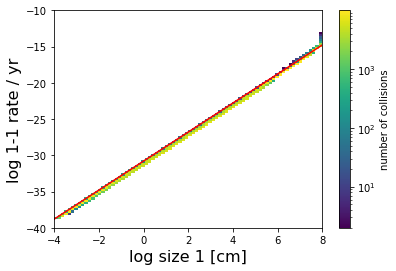

In [77]:
plt.hist2d(size[idx[:,0]],R_flat,range=((sMin,sMax),(-40,-10)),bins=(gps,100),norm=LogNorm())
plt.plot(size,rate(size,size),c='r')
plt.xlabel('log size 1 [cm]',fontsize=16)
plt.ylabel('log 1-1 rate / yr',fontsize=16)
plt.colorbar(label='number of collisions')
plt.show()

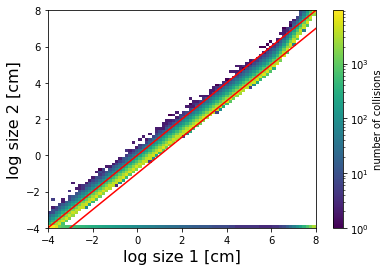

In [80]:
plt.hist2d(size[idx[:,0]],size[idx[:,2]],range=((sMin,sMax),(sMin,sMax)),bins=(gps,gps),norm=LogNorm())
plt.plot(np.linspace(sMin,sMax),np.linspace(sMin,sMax),c='red')
plt.plot(np.linspace(sMin,sMax),np.linspace(sMin,sMax)-1,c='red')
plt.xlabel('log size 1 [cm]',fontsize=16)
plt.ylabel('log size 2 [cm]',fontsize=16)
plt.colorbar(label='number of collisions')
plt.show()

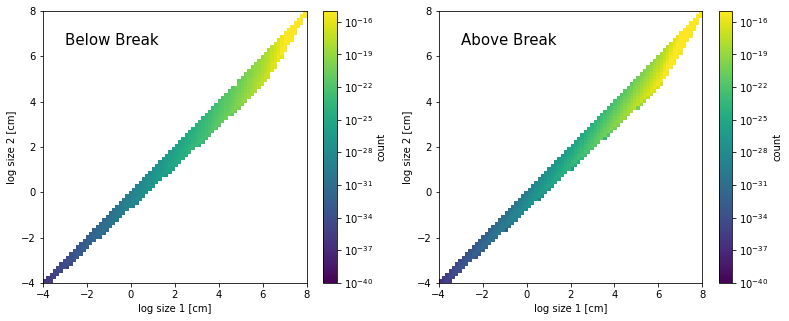

In [81]:
xbelow_foo = size[idx[eccs[idx[:,1]] < efault(size[idx[:,0]]),0]]
ybelow_foo = size[idx[eccs[idx[:,1]] < efault(size[idx[:,0]]),2]]

xabove_foo = size[idx[eccs[idx[:,1]] > efault(size[idx[:,0]]),0]]
yabove_foo = size[idx[eccs[idx[:,1]] > efault(size[idx[:,0]]),2]]

fig,ax=plt.subplots(1,2,figsize=(13,5))

_,_,_,a = ax[0].hist2d(xbelow_foo,ybelow_foo,bins=gps,norm=LogNorm(vmin=1e-40,vmax=1e-15),
                      weights=10**R_flat[eccs[idx[:,1]] < efault(size[idx[:,0]])])
_,_,_,b = ax[1].hist2d(xabove_foo,yabove_foo,bins=gps,norm=LogNorm(vmin=1e-40,vmax=1e-15),
                      weights=10**R_flat[eccs[idx[:,1]] > efault(size[idx[:,0]])])
fig.colorbar(a,ax=ax[0],label='count')
fig.colorbar(b,ax=ax[1],label='count')

ax[0].text(-3,6.5,'Below Break',fontsize=15)
ax[1].text(-3,6.5,'Above Break',fontsize=15)

for i in range(2):
    ax[i].set_xlabel('log size 1 [cm]')
    ax[i].set_ylabel('log size 2 [cm]')
    ax[i].set_xlim(-4,8)
    ax[i].set_ylim(-4,8)

plt.show()

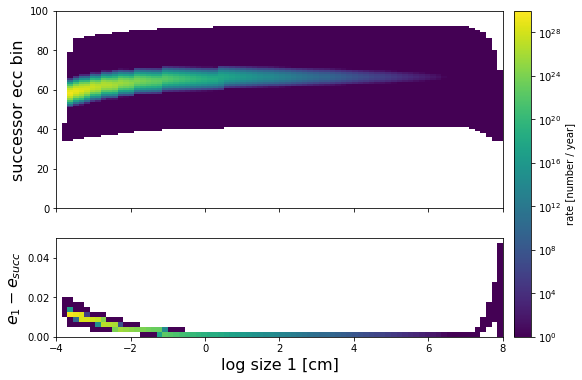

In [79]:
fig,ax = plt.subplots(2,figsize=(8,6),sharex=True,gridspec_kw={'height_ratios': [2,1]})
_,_,_,a = ax[0].hist2d(size[idx[:,0]],esucc_idx,
                       weights=(10**nrem_all[0]),
                       range=((sMin,sMax),(0,gpe)),
                       bins=(gps,gpe),
                       norm=LogNorm(vmin=1e0,vmax=1e30))
ax[0].set_ylabel('successor ecc bin',fontsize=16)

_,_,_,b = ax[1].hist2d(size[idx[:,0]],abs(eccs[esucc_idx.astype(int)] - eccs[idx[:,1]]),
                       weights=(10**nrem_all[0]),
                       range=((sMin,sMax),(0,.05)),
                       bins=(gps,20),
                       norm=LogNorm(vmin=1e0,vmax=1e30))
ax[1].set_xlabel('log size 1 [cm]',fontsize=16)
ax[1].set_ylabel('$e_1 - e_{succ}$',fontsize=16)

cbar_ax = fig.add_axes([0.92, 0.125, 0.03, 0.755])
fig.colorbar(a,cax=cbar_ax,label=r'rate [number / year]')
#plt.savefig('ev_s1_esucc_rate.png',dpi=300)
plt.show()

This is an interesting plot, I think. It shows, for the initial number distribution, how often a particle of a certain size (x-axis) is broken down into particles of a certain eccentricity (y-axis).

## Extra things

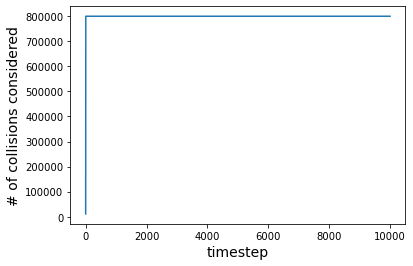

In [76]:
number_considered = np.zeros(ts)
for i in range(ts):
    number_considered[i] = np.count_nonzero(nrem_all[i] > -10)
    
plt.plot(number_considered)
plt.ylabel('# of collisions considered',fontsize=14)
plt.xlabel('timestep',fontsize=14)
plt.show()

In [148]:
def ecc_avg(n):
    """
    In: n -- 2D array; number of elements in each bin of size-ecc space
    
    Out: e_avg -- 1D array; average eccentricity for an object in each size bin
         std -- 1D array; standard deviation for each size bin
    """
    
    n_raw = np.power(10,n)
    weighted = (n_raw.T * eccs).T   # multiplies each row of n by corresponding ecc
    e_avg = np.sum(weighted,axis=0) / np.sum(n_raw,axis=0)
    
    """std = np.zeros(gps)
    for i in range(gps):
        std[i] = np.sum((eccs - e_avg[i]) * n_raw[:,i]) / np.sum(n_raw[:,i])"""
    
    return e_avg #, std

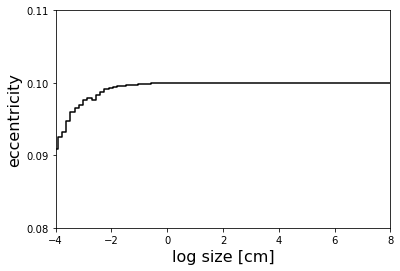

In [149]:
e_foo_mean = ecc_avg(N[3])

plt.errorbar(size,e_foo_mean,e_foo_stds,marker='',ls='',c='k',markersize=2)
plt.step(size,e_foo_mean,where='mid',c='k')
plt.ylim(0.08,.11)
plt.yticks([0.08,0.09,0.10,0.11])
plt.xlim(sMin,sMax)
plt.ylabel('eccentricity',fontsize=16)
plt.xlabel('log size [cm]',fontsize=16)
plt.show()

### Another way of visualizing inflow/outflow at each time

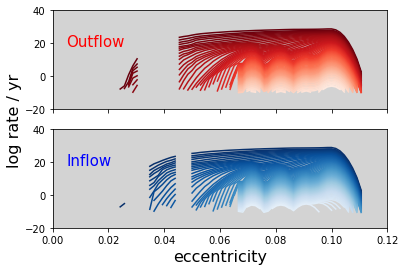

In [153]:
timestep = ts-1

fig,ax=plt.subplots(2,sharex=True)
cmapb = mpl.cm.get_cmap('Blues_r')
cmapr = mpl.cm.get_cmap('Reds_r')

for i in range(gps):
    ax[0].plot(eccs,N_o[timestep,:,i],c=cmapr(3*i))
    ax[1].plot(eccs,N_i[timestep,:,i],c=cmapb(3*i))
for i in range(2):
    ax[i].set_facecolor('lightgrey')
    ax[i].set_xlim(eMin,eMax-.03)
    ax[i].set_ylim(-20,40)

plt.xlabel('eccentricity',fontsize=16)
fig.text(0.02,.5,'log rate / yr',fontsize=16,va='center',rotation='vertical')

ax[0].text(0.005,18,'Outflow',fontsize=15,c='Red')
ax[1].text(0.005,18,'Inflow',fontsize=15,c='Blue')

#fig.savefig('ev_init_rates.png',dpi=300)
plt.show()